# BLEU

## paper

BLEU: a Method for Automatic Evaluation of Machine Translation

https://www.aclweb.org/anthology/P02-1040.pdf

## BLEU 含义解释

BLEU(bilingual evaluation understudy)，简单来说，BLEU算法的思想就是机器翻译的译文越接近人工翻译的结果，它的翻译质量就越高。所以评测算法就是如何定义机器翻译译文与参考译文之间的相似度。

## BLEU 算法计算细节
blog : https://www.cnblogs.com/by-dream/p/7679284.html

code: metric/bleu_2020.py

### N-gram 

BLEU 采用一种N-gram的匹配规则，原理比较简单，就是比较译文和参考译文之间n组词的相似的一个占比。

　　原文：今天天气不错

　　　　机器译文：It is a nice day today

　　　　人工译文：Today is a nice day

　　如果用1-gram匹配的话：

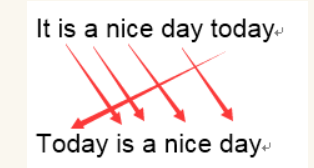
  


  可以看到机器译文一共6个词，有5个词语都命中的了参考译文，那么它1-gram的匹配度为 5/6 

　　我们再以3-gram举例：
  
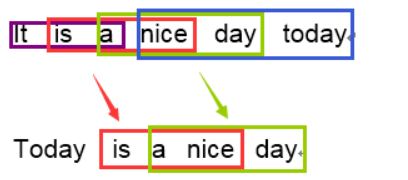
  
  可以看到机器译文一共可以分为四个3-gram的词组，其中有两个可以命中参考译文，那么它3-gram的匹配度为 2/4  

　　依次类推，我们可以很容易实现一个程序来遍历计算N-gram的一个匹配度。一般来说1-gram的结果代表了文中有多少个词被单独翻译出来了，因此它反映的是这篇译文的忠实度；而当我们计算2-gram以上时，更多时候结果反映的是译文的流畅度，值越高文章的可读性就越好。

### Recall

上面所说的方法比较好理解，也比较好实现，但是没有考虑到召回率，举一个非常简单的例子说明：

　　原文：猫站在地上

　　机器译文：the the the the 

　　人工译文：The cat is standing on the ground

　　在计算1-gram的时候，the 都出现在译文中，因此匹配度为4/4 ，但是很明显 the 在人工译文中最多出现的次数只有2次，因此BLEU算法修正了这个值的算法，首先会计算该n-gram在译文中可能出现的最大次数：
  
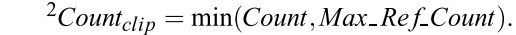

Count是N-gram在机器翻译译文中的出现次数，Max_Ref_Count是该N-gram在一个参考译文中最大的出现次数，最终统计结果取两者中的较小值。然后在把这个匹配结果除以机器翻译译文的N-gram个数。因此对于上面的例子来说，修正后的1-gram的统计结果就是2/4。

### 各阶N-gram的精度 P_n


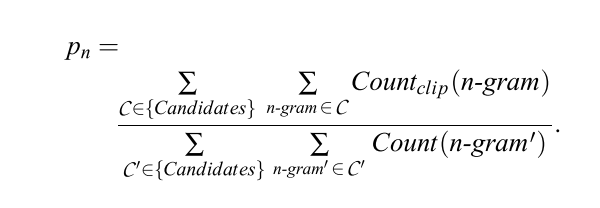

### Brevity Penalty BP 惩罚因子

上面的算法已经足够可以有效的翻译评估了，然而N-gram的匹配度可能会随着句子长度的变短而变好，因此会存在这样一个问题：一个翻译引擎只翻译出了句子中部分句子且翻译的比较准确，那么它的匹配度依然会很高。为了避免这种评分的偏向性，BLEU在最后的评分结果中引入了长度惩罚因子(Brevity Penalty)。

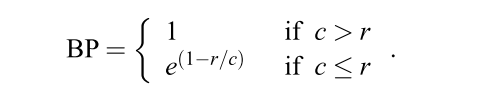

BP的计算公式如上。lc代表表示机器翻译译文的长度，ls表示参考答案的有效长度，当存在多个参考译文时，选取和翻译译文最接近的长度。当翻译译文长度大于参考译文的长度时，惩罚系数为1，意味着不惩罚，只有机器翻译译文长度小于参考答案才会计算惩罚因子。

## BLEU

由于各N-gram统计量的精度随着阶数的升高而呈指数形式递减，所以为了平衡各阶统计量的作用，对其采用几何平均形式求平均值然后加权，再乘以长度惩罚因子，得到最后的评价公式：
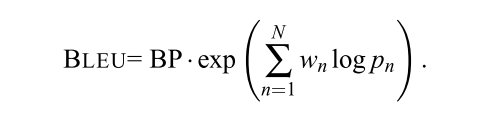
BLEU的原型系统采用的是均匀加权，即Wn=1/N 。N的上限取值为4，即最多只统计4-gram的精度。

# Smoothing Techniques for BLEU

当P_n=0的时候，需要找一个很小的值来代替，于是就有了smooth function

## paper

A Systematic Comparison of Smoothing Techniques for Sentence-Level BLEU Boxing Chen and Colin Cherry

https://www.aclweb.org/anthology/W14-3346/

## Smoothing Techniques




soomthing method 1-3都是之前的提出的，method 4-7是改进版，因为method 3忽略了长度，method4在计算的时候考虑到了predict的senttence的长度。


公式说明，之前的n-gram精度的分子于分母为

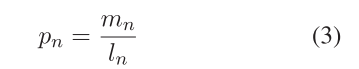

### method 1

P_n的分子用一个小的数 $\epsilon $ 来代替

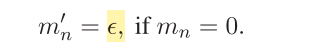

相当于

$$ p_n = \frac{\epsilon}{l_n} \quad , \quad  \epsilon = 0.1 $$


### method 2

当n 大于等于2 的时候， 上下加1

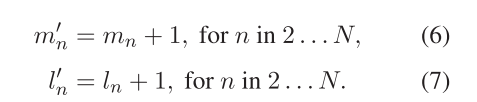

### method 3

分子$m_n$换成等比数列 $ \frac{1}{2^k}$, k是第几次出现0的次数.

$$m_n = \frac{1}{2^k}$$

### method 4

没有考虑到predict 的length。 会在较短的时候夸大bleu的值，所以需要考虑到predict len
(1/(3+5/(math.log(x1)))

$$ m_n = \frac{1}{n -1 +\frac{k}{log(l_n)} }$$

k=5，l_n为8，计算4gram的时候

$$ m_4 = \frac{1}{3 +\frac{5}{log(8)} }$$

### method 5

相近的gram应该有相似的分数，于是加权平均其他gram



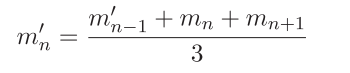

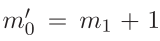

###  method 6

最大似然估计的插值
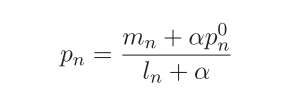


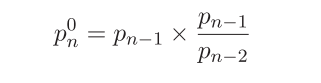

### method 7



先用method4 平滑，在用method5计算

# Different BLEU

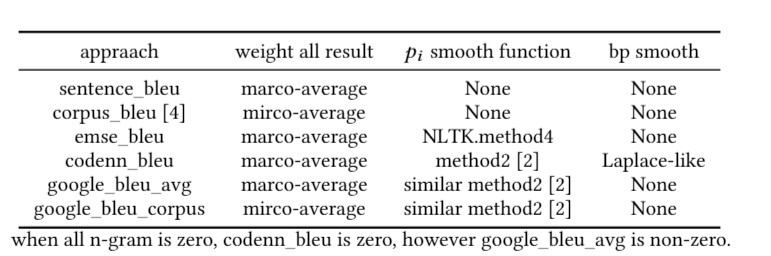

* NLTK各个版本对于soomth4的实现都有问题
* NLTK和google bleu对于method2的实现，背离了N大于等于2，才使用拉普拉斯的上下加1来光滑，而是对所有gram进行光滑
* Codenn符合method2的实现
* NLTK在实现method2的时候加了判断条件，对于1-gram为0的话直接返回0，而不再进行光滑，google bleu依旧及逆行光滑
* BP这里基本上没有人用光滑函数，codenn用了, 就是r和c上下加1


$B P=\left\{\begin{array}{cl}1 & \text { if } c>r \\ e^{(1-(r+1) / (c+1))} & \text { if } c \leq r\end{array}\right.$